# Intro Task, Object Localization

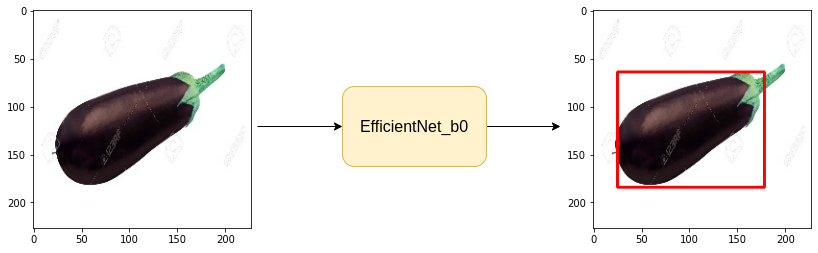

In [8]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6jfk1wql
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6jfk1wql
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [9]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [10]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [11]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [12]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [13]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

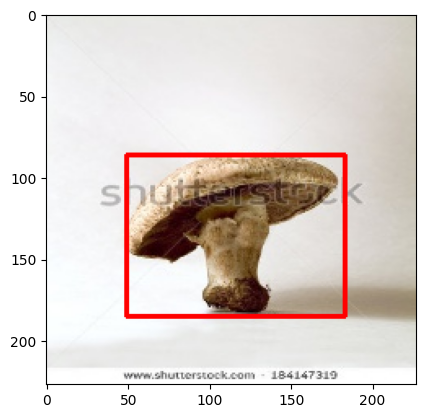

In [17]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

# Augmentations

In [15]:
import albumentations as A

In [15]:
train_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [15]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]] # Albumentation use this format

    img_path = DATA_DIR + row.img_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox, class_labels = [None]) # only localize => don't need class_labels
      img = data['image']
      bbox = data['bboxes'][0]  # get from format: [[xmin, ymin, xmax, ymax]]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0  # torch use (channel, height, weight) => shift channel-axis to 0-axis. So (h,w,c)->(c,h,w)
    bbox = torch.Tensor(bbox)

    return img,bbox

In [15]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [15]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

In [16]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

NameError: ignored

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

In [ ]:
for images,bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
timm.list_models('*efficient*')

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)  # output w/o softmax ???

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss

    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE)

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)  # batch, channel, height, width
model(random_img).shape

# Create Train and Eval Function

In [ ]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() # train model -> Dropout ON

  # tqdm to track batch
  for data in tqdm(dataloader):
    img,gt_bboxes = data  # gt_bboxes = ground truth
    img,gt_bboxes = img.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(img, gt_bboxes)  # model predict

    # gradient steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def valid_fn(model,dataloader):
  total_loss = 0.0
  model.eval() # evaluate model -> Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader): # tqdm to track batch
      img, gt_bboxes = data
      img, gt_bboxes = img.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(img, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader) # avg loss

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} train loss: {train_loss} valid loss: {valid_loss}")

#Inference

In [ ]:
import utils

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

with torch.no_grad():
  image, gt_box = validset[5] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_box, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya